In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
%matplotlib inline 
import sys, os 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.
import pygraphviz
from causalnex.structure import StructureModel
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from IPython.display import Image


In [28]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocess import check_numeric, label_encode
from file_read import FileHandler
from structure import Structure
# from exploration import Exploration
filehandler = FileHandler()
structure = Structure()


In [3]:
# reading data
data = filehandler.read_csv('../input/data.csv')

## Preparing the Data for Structure Learning
### since id doesn't have significance for the output we will drop it out and also unnamed column is nan

In [29]:
# y includes our labels and x includes our features
df, non_numeric_cols = check_numeric(data)
df = label_encode(df, non_numeric_cols)
y = data.diagnosis                          # M or B 
list = ['Unnamed: 32','id','diagnosis']
x = data.drop(list,axis = 1 )
x.head()

INFO:preprocess:encodes label for non_numeric successfully


[]


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Splitting data into training and test set for feature selection

In [5]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

### using univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features..

In [6]:
# find best scored 8 features
select_feature = SelectKBest(chi2, k=8).fit(x_train, y_train)

In [7]:
print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

Score list: [2.34537862e+02 8.46171475e+01 1.77484577e+03 4.76672868e+04
 1.51026517e-01 4.96541930e+00 1.75324567e+01 9.43537070e+00
 2.76631367e-01 3.96257165e-06 3.18011479e+01 2.90948841e-04
 2.27721391e+02 7.93553164e+03 1.12490005e-03 5.62662568e-01
 9.29991444e-01 2.93945730e-01 9.36481631e-05 4.89781704e-03
 4.33623580e+02 1.59402611e+02 3.22741118e+03 9.94228172e+04
 3.99113116e-01 1.76988015e+01 3.53915891e+01 1.21674048e+01
 1.31136533e+00 2.11661786e-01]
Feature list: Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'c

our best 8 features are ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean']

### so we will be using this number of feature for our causal graph

## Structure from Domain Knowledge
### We can manually define a structure model by specifying the relationships between different features.

### First, we must create an empty structure model.

In [8]:
sm = StructureModel()

### We can apply now the NOTEARS algorithm to learn the structure

In [9]:
#filter original dataset to retain the important features
#the dimension of the dataset has reduced from 569,32 to 569,9
stru_data = data [['diagnosis','area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst',
       'perimeter_worst', 'area_worst', 'concavity_worst',
       'concave points_worst']]
stru_data.head()
sm = from_pandas(stru_data)

INFO:structure:plots causal graph successfully


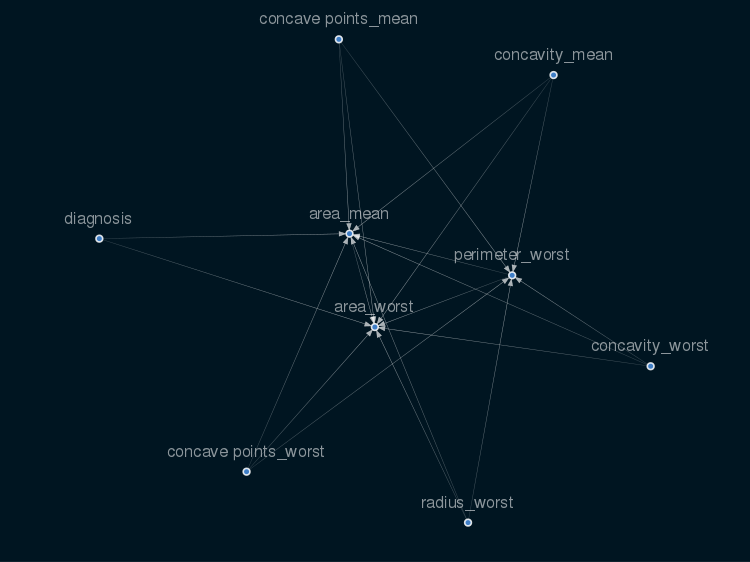

In [10]:
viz = structure.drawgraph(sm)
# drawing the image
Image(viz.draw(format='png'))

In [11]:
#add constraint to diagnosis without lasso regularization
sm_constrained = from_pandas(stru_data, tabu_parent_nodes=['diagnosis'], w_threshold=0.8)

INFO:structure:plots causal graph successfully


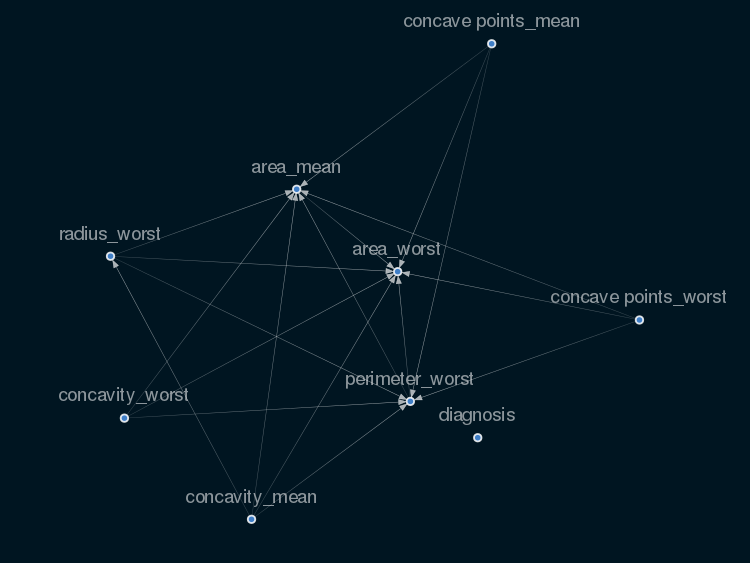

In [12]:
viz = structure.drawgraph(sm_constrained)
Image(viz.draw(format='png'))

INFO:structure:plots causal graph successfully


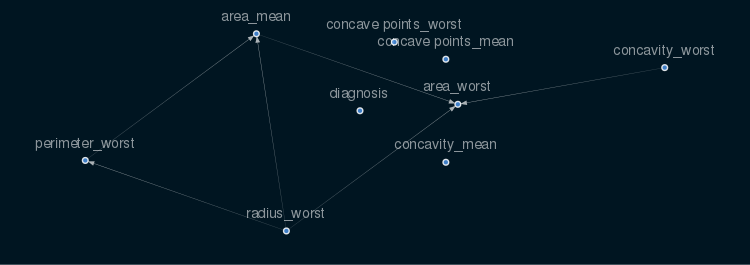

In [16]:
#put constraint on diagnosis column with lasso regularization
sm_lasso = from_pandas_lasso(stru_data, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = structure.drawgraph(sm_lasso)
# draws graph of lassso regularized
Image(viz.draw(format='png'))

## Structure Review
## concavity affects  and area
## Radius affects perimeter and area,

### the graph captures these relationships.


## Jaccard's similarity index

In [31]:
#similarity between a graph plotted without lasso regularization and one plotted with lasso regularization
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

jaccard_similarity(sm_constrained.edges(), sm_lasso.edges())

0.316

### Using Union and intersection

In [33]:
def jaccar_score(g, h):    
    i = set(g).intersection(set(h))
    u = set(g).union(set(h))
    return len(i) / float(len(u))
jaccar_score(sm_constrained.edges(), sm_lasso.edges())

0.3157894736842105

### The score and similarity are pretty much the same let us if we can increase this number. let us Split the data row wise and test the model as we increase the data 

In [34]:
df_1 = stru_data.iloc[:100,:]
df_2 = stru_data.iloc[:200,:]
df_3 = stru_data.iloc[:300,:]
df_3 = stru_data.iloc[:400,:]

INFO:structure:plots causal graph successfully


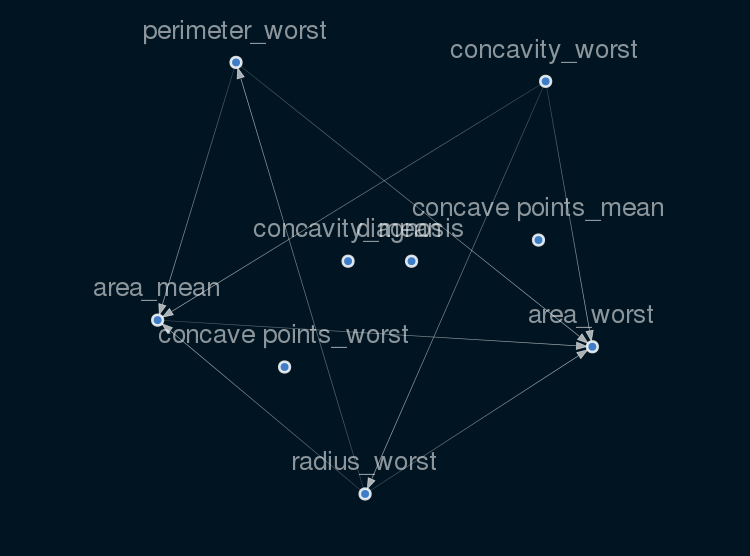

In [36]:
sm_df1 = from_pandas_lasso(df_1, tabu_parent_nodes=['diagnosis'], w_threshold=0.8, beta=0.8)
viz = structure.drawgraph(sm_df1)
Image(viz.draw(format='png'))